<a href="https://colab.research.google.com/github/akchen1/CMPUT466-Project/blob/linreg/CMPUT466_LinReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages


In [ ]:
!pip install -q seaborn
!pip install -q tensorflow
!pip install -U scikit-learn
!pip install -U lime
!pip install -U pandas

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
Requirement already up-to-date: lime in /usr/local/lib/python3.7/dist-packages (0.2.0.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.4)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from lime import lime_tabular
from sklearn.pipeline import make_pipeline
from matplotlib.pyplot import figure
from sklearn.compose import ColumnTransformer
import datetime
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model

# Data Analysis

In [ ]:
dataset = pd.read_csv("./Melbourne_housing_FULL.csv", header=0)

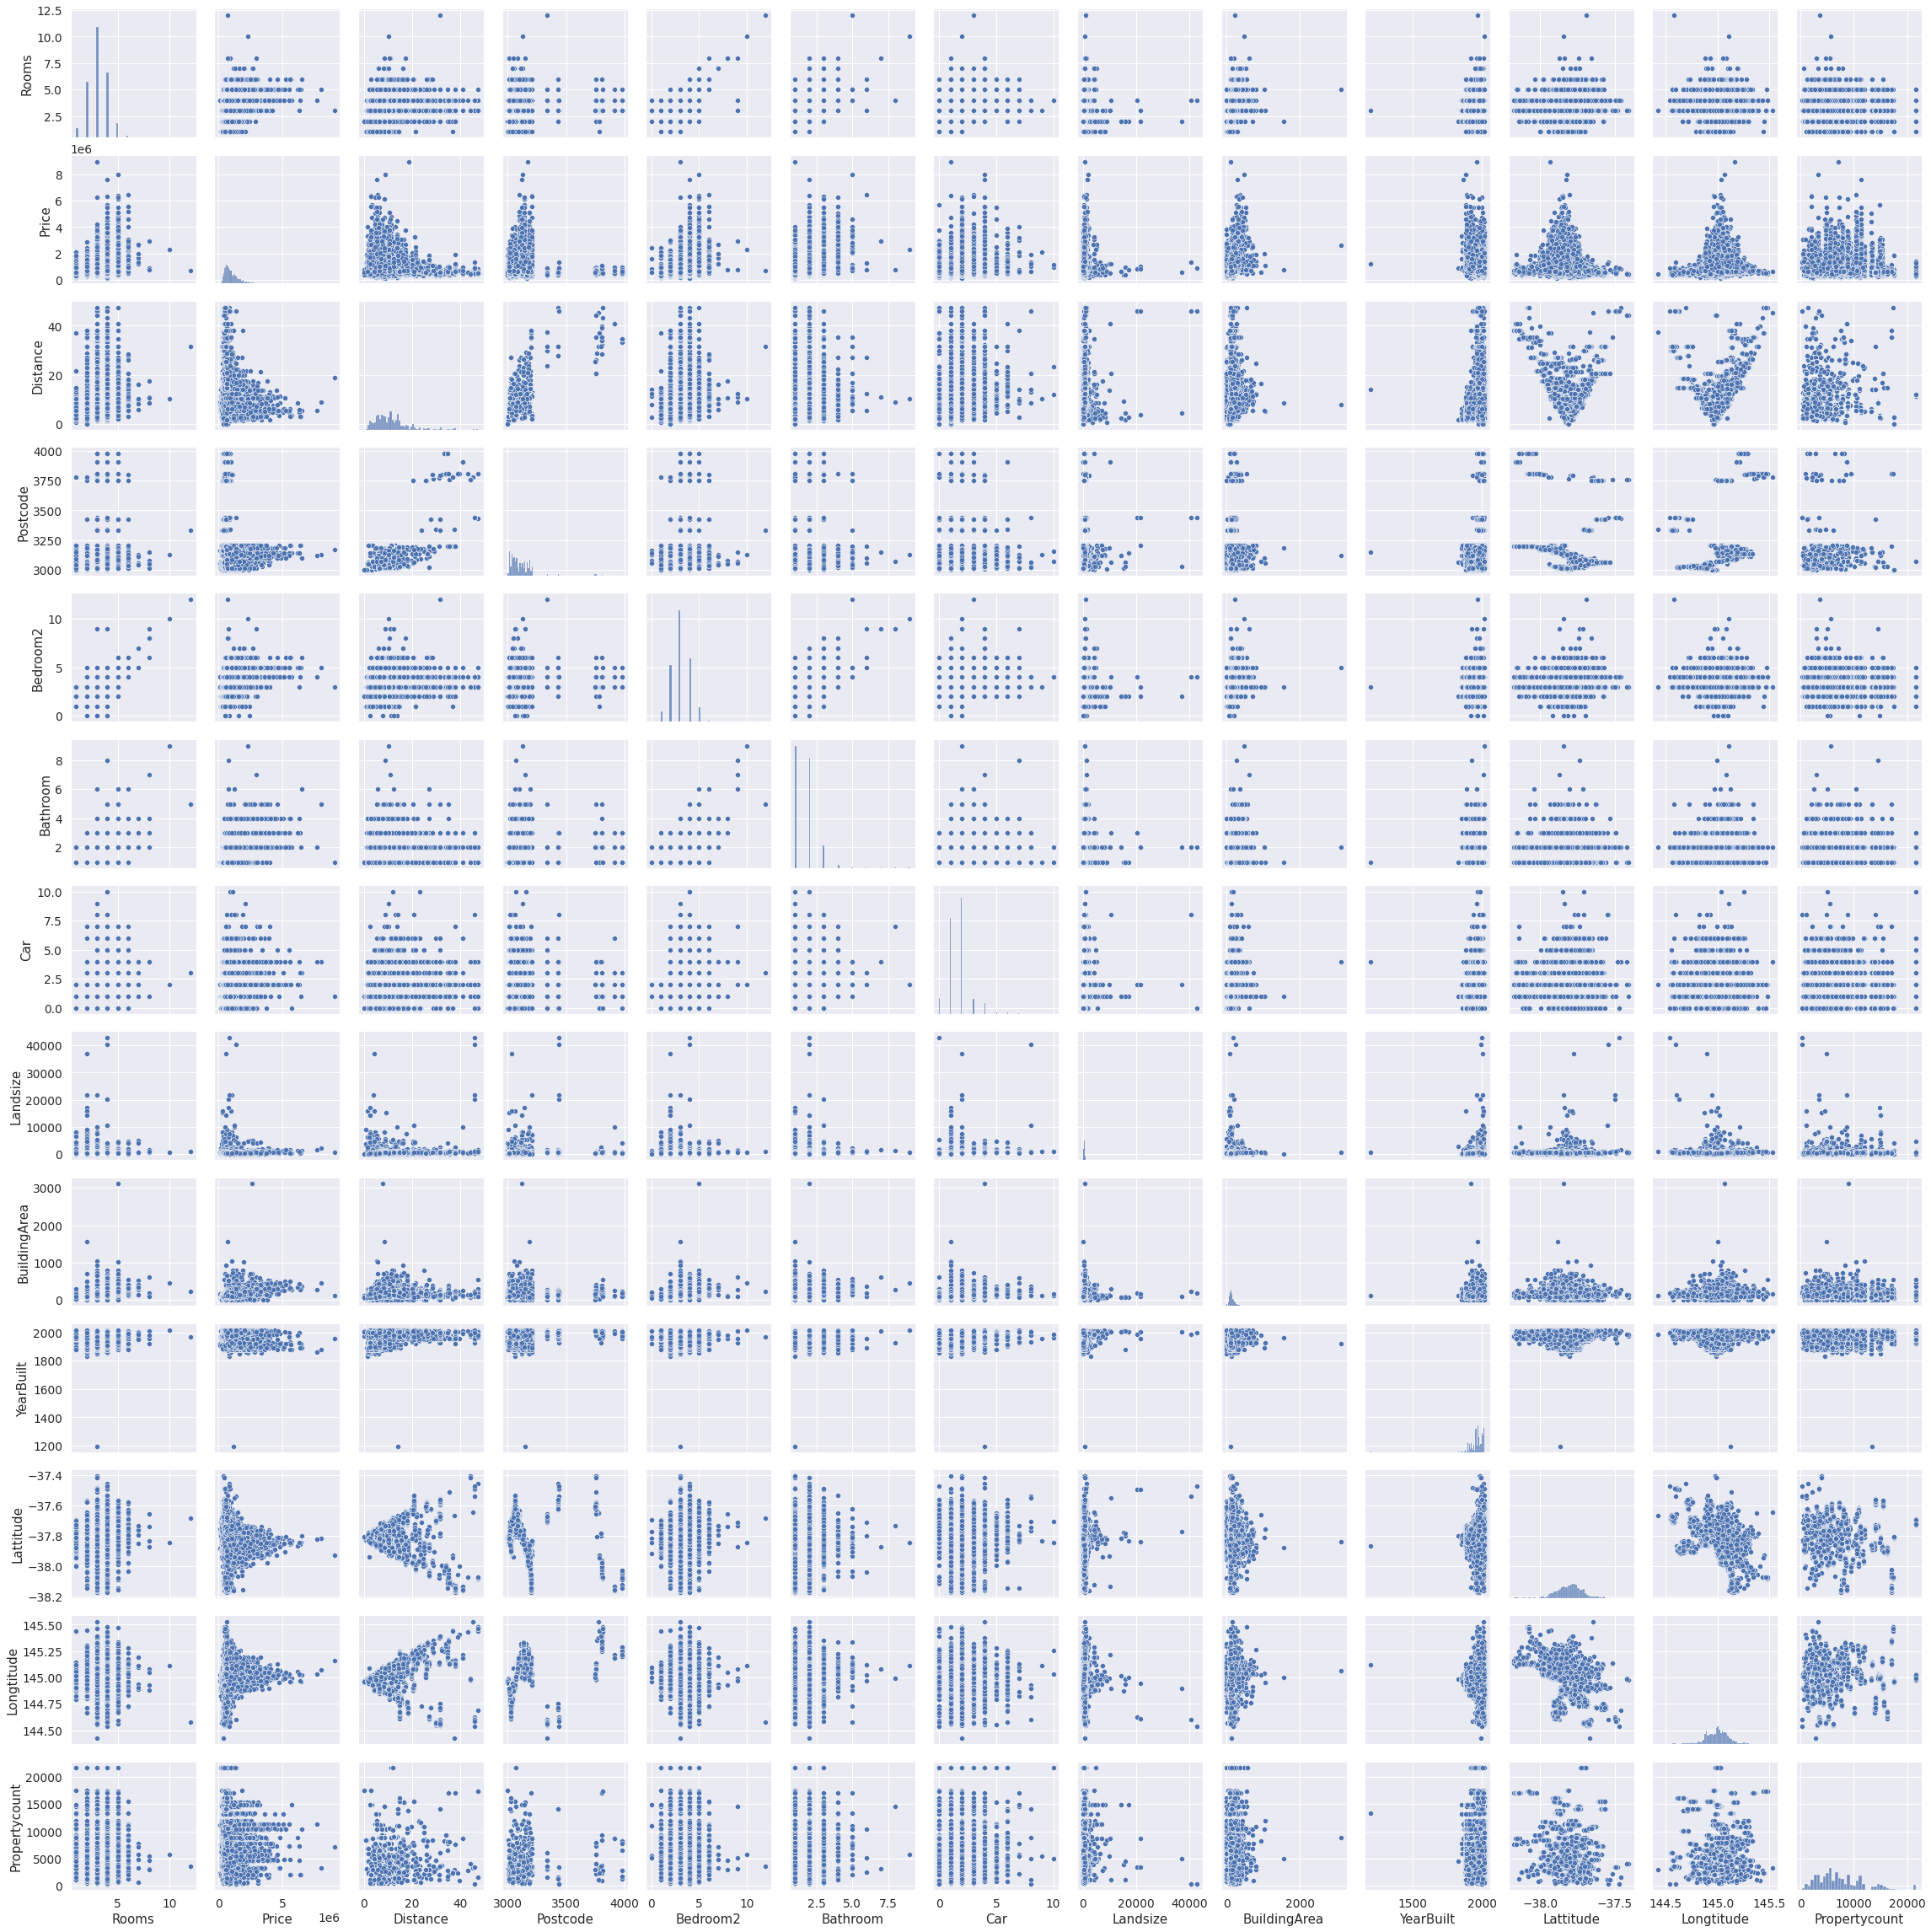

In [ ]:
sns.pairplot(raw_dataset.dropna())

Correlation Matrix

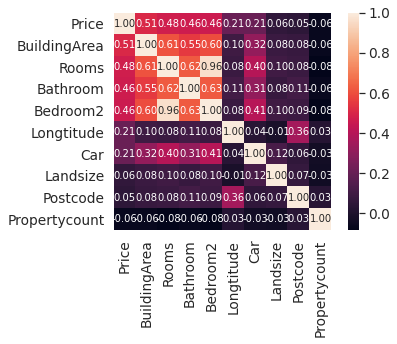

In [ ]:
k = 10
dataset = dataset.dropna()

corrmat = dataset.corr()
cols = corrmat.nlargest(k, "Price")["Price"].index
cm = np.corrcoef(dataset[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Linear Regression

Import data


In [ ]:
raw_dataset = pd.read_csv("./Melbourne_housing_FULL.csv", header=0)
cols = ['Rooms', 'Type', 'Regionname', 'Price', 'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'BuildingArea', 'Distance']

dataset = raw_dataset.copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

Data processing


In [ ]:
# Drop columns that contain null values
dataset = dataset[cols]
dataset = dataset.dropna()

# One hot encode feature Type (H: houses, U: units, T: townhouses)
dataset = pd.concat([dataset, pd.get_dummies(dataset['Type'], prefix='Type')],axis=1)
dataset.drop('Type', axis=1, inplace=True)

# One hot encode feature Regionname
df_region = dataset.copy()
regionname_dummies = pd.get_dummies(df_region['Regionname'])
df_region = pd.concat([df_region, regionname_dummies], axis = 1)
df_region = df_region.drop(['Regionname'], axis = 1)
df_region.head()


Rooms      Price  ...  Western Metropolitan  Western Victoria
2       2  1035000.0  ...                     0                 0
4       3  1465000.0  ...                     0                 0
6       4  1600000.0  ...                     0                 0
11      3  1876000.0  ...                     0                 0
14      2  1636000.0  ...                     0                 0

[5 rows x 19 columns]

In [ ]:
age_groups = [0, 1, 2, 3, 5, 10, 20, 100]

# Supporting function to one hot encode the year built feature into decade groups
def divide_data_by_age_groups(year_built):
    if pd.isnull(year_built):
        return 9999
    age = datetime.datetime.now().year - year_built
    if (age % 10) >= 5:
        age_decades = ((age // 10) + 1)
    else:
        age_decades = (age // 10)

    for group in age_groups:
        if age_decades <= group:
            age_decades = group
            break
    return age_decades

In [ ]:
# One hot encode YearBuilt feature and group into decades
df_date = df_region.copy()
df_date['AgeInDecades'] = df_date['YearBuilt'].apply(divide_data_by_age_groups)
decades_dummies = pd.get_dummies(df_date['AgeInDecades'])

column_names = ['0_Decades_Old', '1_Decades_Old', '2_Decades_Old', '3_Decades_Old', '5_Decades_Old', '10_Decades_Old', '20_Decades_Old', '100_Decades_Old']
decades_dummies.columns = column_names

df_date = df_date.drop(['AgeInDecades', 'YearBuilt'], axis = 1)

df_date = pd.concat([df_date, decades_dummies], axis = 1)

# Drop 100 decade old column. Found to improve results
df_date = df_date.drop(df_date[df_date['100_Decades_Old']==1].index, axis=0)
df_date = df_date.drop(['100_Decades_Old'], axis=1)

In [ ]:
# Standarize features Landsize, BuilindgArea, and Distance to relative weights are similar
scaled_features = df_date.copy()
col_names = ['Landsize', 'BuildingArea', 'Distance']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features


Split data into training and test data


In [ ]:
df = scaled_features.copy()
y = df['Price']
df = df.drop(['Price'], axis = 1)
train_X, test_X, train_y, test_y = train_test_split(df, y,train_size=0.8, random_state=11)
test_X.head()

Rooms  Bathroom  Car  ...  5_Decades_Old  10_Decades_Old  20_Decades_Old
14726      3       3.0  1.0  ...              0               0               0
5237       3       1.0  1.0  ...              0               0               1
9697       3       1.0  2.0  ...              0               1               0
4965       4       1.0  2.0  ...              0               1               0
33794      2       1.0  2.0  ...              1               0               0

[5 rows x 24 columns]

Training the model using differnet polynomial degrees with regularization


In [ ]:
# Degree 1
model_degree1 = make_pipeline(PolynomialFeatures(degree=1), linear_model.Ridge(alpha=1))
model_degree1.fit(train_X, train_y)
predictions_degree1 = model_degree1.predict(test_X)
# Degree 2
model_degree2 = make_pipeline(PolynomialFeatures(degree=2), linear_model.Ridge(alpha=1))
model_degree2.fit(train_X, train_y)
predictions_degree2 = model_degree2.predict(test_X)

Performance


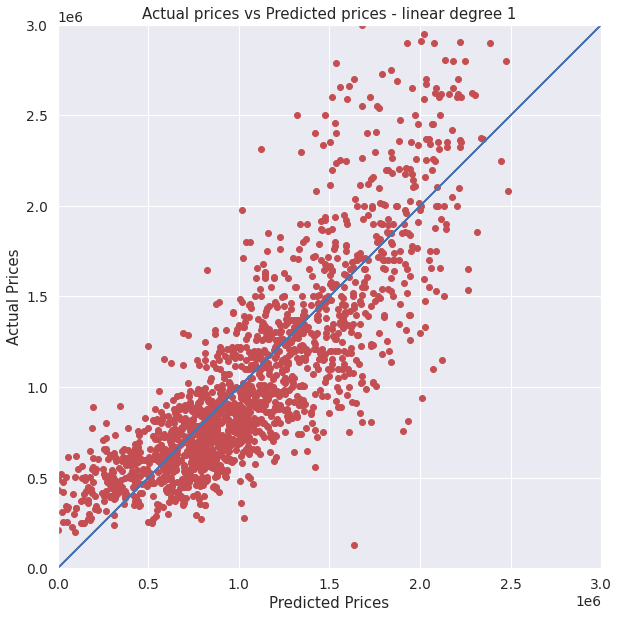

In [ ]:
# Performance of degree 1
plt.figure(figsize=(10,10))
plt.plot(predictions_degree1, test_y, 'ro')
plt.plot(predictions_degree1, predictions_degree1)

plt.ylim([0,3000000])
plt.xlim([0,3000000])
plt.title("Actual prices vs Predicted prices - linear degree 1")
plt.xlabel("Predicted Prices")
plt.ylabel("Actual Prices")
plt.gca().set_aspect('equal', adjustable='box')

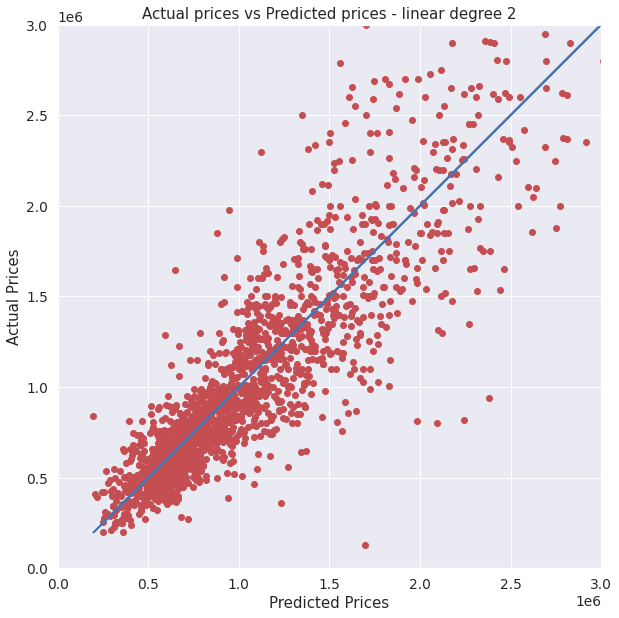

In [ ]:
# Performance of degree 2
plt.figure(figsize=(10,10))
plt.plot(predictions_degree2, test_y, 'ro')
plt.plot(predictions_degree2, predictions_degree2)

plt.ylim([0,3000000])
plt.xlim([0,3000000])
plt.title("Actual prices vs Predicted prices - linear degree 2")
plt.xlabel("Predicted Prices")
plt.ylabel("Actual Prices")
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
# Mean Squared Error
MSE_degree1 = mean_squared_error(test_y, predictions_degree1)
MSE_degree2 = mean_squared_error(test_y, predictions_degree2)

# Mean Absolute Error
MAE_degree1 = mean_absolute_error(test_y, predictions_degree1)
MAE_degree2 = mean_absolute_error(test_y, predictions_degree2)

# Mean Absolute Percent Error
MAPE_degree1 = mean_absolute_percentage_error(test_y, predictions_degree1)
MAPE_degree2 = mean_absolute_percentage_error(test_y, predictions_degree2)

# R2 score
r2_degree1 = r2_score(test_y, predictions_degree1)
r2_degree2 = r2_score(test_y, predictions_degree2)

# Cross validation
scores_degree1 = cross_val_score(model_degree1, train_X, train_y, scoring="r2", cv=5)
scores_degree2 = cross_val_score(model_degree2, train_X, train_y, scoring="r2", cv=5)

print("--------------------Degree 1--------------------")
print("CV score - r2 {}".format(scores_degree1))
print("CV score - r2 avg {}".format(np.average(scores_degree1)))
print("Mean squared error {}".format(MSE_degree1))
print("Mean absolute error {}".format(MAE_degree1))
print("Mean absolute percent error {}".format(MAPE_degree1))
print("R2 score {}".format(r2_degree1))
print("--------------------Degree 2--------------------")
print("CV score - r2 {}".format(scores_degree2))
print("CV score - r2 avg {}".format(np.average(scores_degree2)))
print("Mean squared error {}".format(MSE_degree2))
print("Mean absolute error {}".format(MAE_degree2))
print("Mean absolute percent error {}".format(MAPE_degree2))
print("R2 score {}".format(r2_degree2))

--------------------Degree 1--------------------
CV score - r2 [0.70093138 0.60157674 0.58011052 0.63984856 0.64560767]
CV score - r2 avg 0.6336149747487883
Mean squared error 145169576803.9039
Mean absolute error 255190.10576094384
Mean absolute percent error 0.2790482100570206
R2 score 0.6770514669739076
--------------------Degree 2--------------------
CV score - r2 [0.75808009 0.29329685 0.68075133 0.70995635 0.72939717]
CV score - r2 avg 0.6342963586868251
Mean squared error 100576973471.5051
Mean absolute error 200060.80862167332
Mean absolute percent error 0.2030511283941819
R2 score 0.7762534908901566


Interpretation

In [ ]:
# Degree 1
feature_names_degree1 = (model_degree1.named_steps['polynomialfeatures']
                      .get_feature_names(input_features=train_X.columns))
feature_names_degree1 = feature_names_degree1[1:]

coefs_degree1 = pd.DataFrame(
    model_degree1.named_steps['ridge'].coef_[1:],
    columns=['Coefficients'], index=feature_names_degree1
)

# Degree 2
feature_names_degree2 = (model_degree2.named_steps['polynomialfeatures']
                      .get_feature_names(input_features=train_X.columns))
feature_names_degree2 = feature_names_degree2[1:]

coefs_degree2 = pd.DataFrame(
    model_degree2.named_steps['ridge'].coef_[1:],
    columns=['Coefficients'], index=feature_names_degree2
)

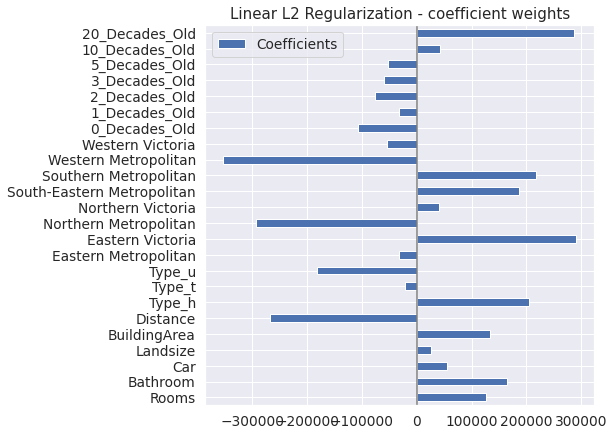

In [ ]:
# Degree 1
coefs_degree1.plot(kind='barh', figsize=(9, 7))
plt.title('Linear L2 Regularization - coefficient weights')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

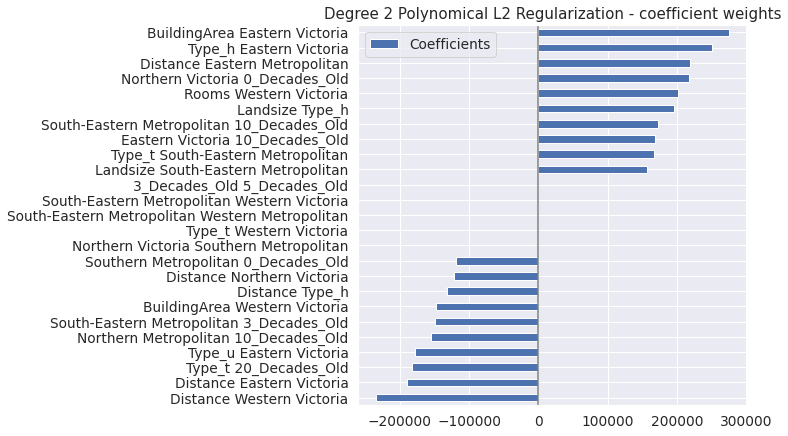

In [ ]:
# Degree 2
# Showing the top 10 positive and negative weight and weights with little impact
sorted = coefs_degree2.sort_values("Coefficients")
sorted = sorted[:10].append(sorted[125:130]).append(sorted[-10:])
sorted.plot(kind='barh', figsize=(9, 7))
plt.title('Degree 2 Polynomical L2 Regularization - coefficient weights')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

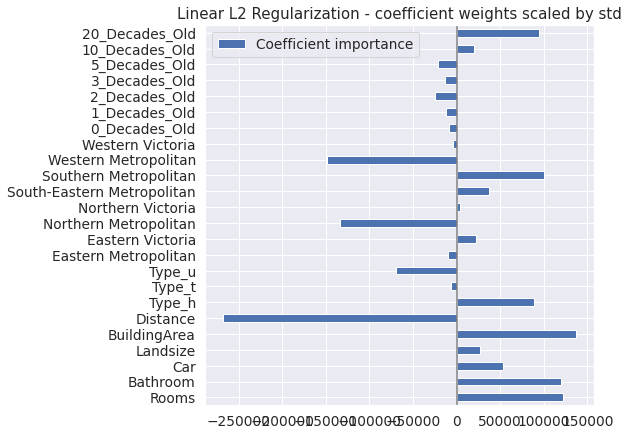

In [ ]:
# Additional analysis of linear model
# Scale the coefficients using std
coefs_degree1_scaled = pd.DataFrame(
    model_degree1.named_steps['ridge'].coef_[1:]*train_X.std(axis=0),
    columns=['Coefficient importance'], index=feature_names_degree1
)

coefs_degree1_scaled.plot(kind='barh', figsize=(9, 7))
plt.title('Linear L2 Regularization - coefficient weights scaled by std')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Find some cases that are misclassified and run lime with them


In [ ]:
num_over_degree1 = 0;
num_under_degree1 = 0;
num_over_degree2 = 0;
num_under_degree2 = 0;
idxs_degree1 = []
idxs_degree2 = []

# Degree 1
for i, (yi_p, yi_t) in enumerate(zip(predictions_degree1, test_y)):
  if(abs((yi_p - yi_t)/yi_t) > 0.3): # Look at ones with > 30% percent difference
    if yi_p > yi_t:
      num_over_degree1 += 1
    else:
      num_under_degree1 += 1
  else:
    idxs_degree1.append(i)

# Degree 2
for i, (yi_p, yi_t) in enumerate(zip(predictions_degree2, test_y)):
  if(abs((yi_p - yi_t)/yi_t) > 0.3): # Look at ones with > 30% percent difference
    if yi_p > yi_t:
      num_over_degree2 += 1
    else:
      num_under_degree2 += 1
  else:
    idxs_degree2.append(i)

print("--------------------Degree 1--------------------")
print("Over predicted {}", num_over_degree1)
print("Under predicted {}", num_under_degree1)
print("--------------------Degree 2--------------------")
print("Over predicted {}", num_over_degree2)
print("Under predicted {}", num_under_degree2)


--------------------Degree 1--------------------
Over predicted {} 381
Under predicted {} 224
--------------------Degree 2--------------------
Over predicted {} 246
Under predicted {} 99


In [ ]:
explainer = lime_tabular.LimeTabularExplainer(np.array(train_X),
                    feature_names=train_X.columns, 
                    class_names=['Price'],                             
                    verbose=True, mode='regression')

In [ ]:
# Degree 1
for idx in idxs_degree1[:2]:
  print("actual price {}".format( test_y.iloc[idx]))
  exp = explainer.explain_instance(test_X.iloc[idx], 
      model_degree1.predict, num_features=26)
  exp.show_in_notebook(show_table=True, show_all=False)

actual price 1500000.0
Intercept 853101.80872564
Prediction_local [1598418.44842065]
Right: 1411544.316321848


actual price 1741000.0
Intercept 459355.36864101794
Prediction_local [1659497.21311159]
Right: 1794018.9143010392


In [ ]:
# Degree 2
for idx in idxs_degree2[:2]:
  print("actual price {}".format( test_y.iloc[idx]))
  exp = explainer.explain_instance(test_X.iloc[idx], 
      model_degree2.predict, num_features=26)
  exp.show_in_notebook(show_table=True, show_all=False)

actual price 1500000.0
Intercept 2515915.5550365527
Prediction_local [1654549.79284386]
Right: 1535763.1590739756


actual price 1741000.0
Intercept 1667270.4518915566
Prediction_local [1740089.85922891]
Right: 1712237.7085531577
